In [7]:
import os, sys, time, resource, re, gc, shutil, math
from nltk import ngrams
from multiprocess import Pool
from functools import partial
from mongoengine import *
from urllib.parse import urlparse, parse_qsl
import numpy as np
import pandas as pd
connect('mongoengine_documents')
import matplotlib.pyplot as plt

from gensim.models import Word2Vec, Doc2Vec
from gensim.models import Phrases
import gensim

import django

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

import pymongo
from pymongo import MongoClient
from monary import Monary
mon = Monary()
#client = MongoClient()
#db = client.documents
#scopus_docs = db.scopus_docs

from mongo_classes import *

In [30]:
s_docs = scopus_doc.objects.filter(DO__exists=True).count() 
print(s_docs)
w_docs = Doc.objects.filter(
        UT__UT__icontains="WOS:",
        query=365,
        wosarticle__di__isnull=False
        #PY=d1.PY,title__icontains=d1word
    ).count()
print(w_docs)

print(f"{s_docs*w_docs:,}")

281748
249644
70,336,697,712


In [8]:
similarity.objects.count()

3744660

In [9]:
scopus_doc.objects.filter(doc2vec_checked=True).count()

15

In [10]:
sims = similarity.objects.filter(doc2vec_sim__gt=0)
sims.count()

2680314

In [11]:
similarity.objects.filter(doc2vec_sim__gt=0,jaccard=0).count()


2572609

In [12]:
columns, types = zip(*[
    ('do_match', 'bool'), 
    ('doc2vec_sim', 'float32'),
    ('jaccard', 'float32'),
    ('wc_diff', 'int8'),
    ('wc', 'int8'),
    ('t_match', 'bool'),
    ('doc2vec_rank', 'int16')  
])

numpy_arrays = mon.query(
    'mongoengine_documents', 
    'similarity', 
    { "doc2vec_sim": 
     {"$exists": True},
     "scopus_do":True, 
     "wos_do": True
    },
    columns, 
    types
)
df = np.matrix(numpy_arrays).transpose() 
df = pd.DataFrame(df, columns=columns)
print(df.shape)
df.head()

(3744660, 7)


,do_match,doc2vec_sim,jaccard,wc_diff,wc,t_match,doc2vec_rank
0,0.0,-0.168446,0.0,1.0,8.0,0.0,0.0
1,0.0,-0.103988,0.0,8.0,13.0,0.0,0.0
2,0.0,-0.038457,0.0,7.0,12.0,0.0,0.0
3,0.0,0.115184,0.0,2.0,8.0,0.0,0.0
4,0.0,0.283324,0.0,8.0,13.0,0.0,0.0


0.0
0
1.0


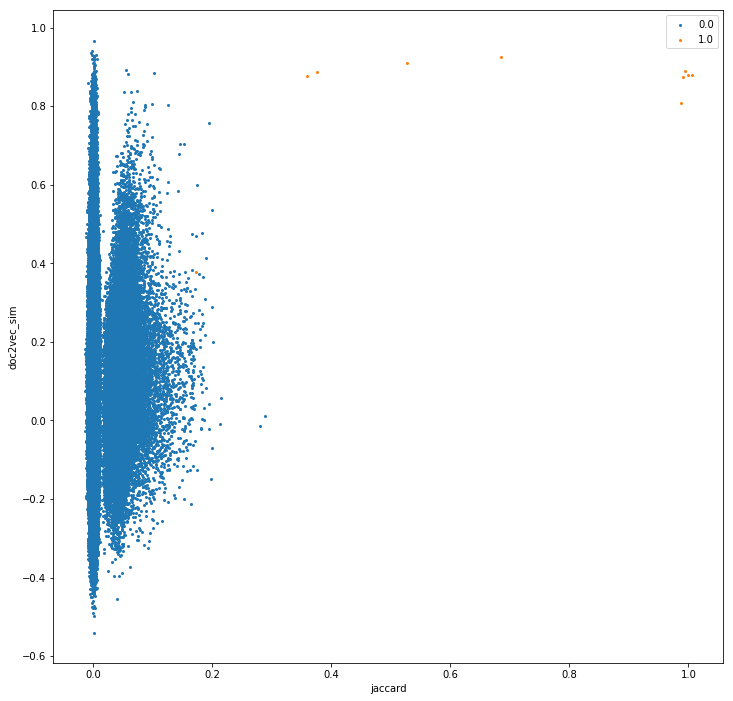

In [13]:
pdf = df#.sample(frac=0.5, replace=True)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

for name, group in pdf.groupby('do_match'):
    print(name)
    if name==0.0:
        print("0")
        group = group.sample(1000000)
    jitter(
        group['jaccard'], 
        group['doc2vec_sim'], 
        s=4, 
        cmap='Set1',
        label=name
    )

plt.legend()
plt.xlabel('jaccard')
plt.ylabel('doc2vec_sim')

plt.show()

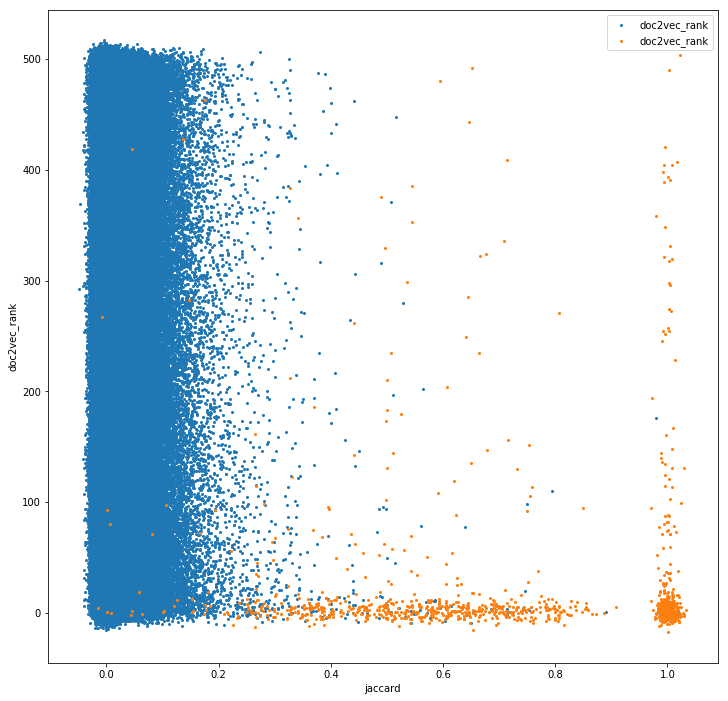

In [34]:
pdf = df#.sample(frac=0.5, replace=True)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

for name, group in pdf.groupby('do_match'):
    jitter(group['jaccard'], group['doc2vec_rank'], s=4, cmap='Set1')

plt.legend()
plt.xlabel('jaccard')
plt.ylabel('doc2vec_rank')

plt.show()

In [31]:
numpy_arrays = mon.query(
    'mongoengine_documents', 
    'similarity', 
    { "doc2vec_sim": {"$exists": True}, 
     "do_match": True
    },
    columns, 
    types
)
matches = np.matrix(numpy_arrays).transpose() 
match_df = pd.DataFrame(matches, columns=columns)

print(similarity.objects.filter(doc2vec_sim__gt=0,do_match=True).count())

match_df.head(13)

#match_df = pd.DataFrame.from_dict(list(matches.values()))



1134


,do_match,doc2vec_sim,jaccard,wc_diff,wc,t_match,doc2vec_rank
0,1.0,0.853627,0.583333,1.0,10.0,0.0,1.0
1,1.0,0.774050,0.333333,1.0,15.0,0.0,1.0
2,1.0,0.404488,1.000000,0.0,7.0,0.0,403.0
3,1.0,0.785351,1.000000,0.0,8.0,0.0,1.0
4,1.0,0.357924,0.176471,20.0,21.0,0.0,466.0
5,1.0,0.698355,0.583333,1.0,10.0,0.0,1.0
6,1.0,0.803337,0.375000,0.0,12.0,0.0,3.0
7,1.0,0.862345,1.000000,0.0,9.0,0.0,1.0
8,1.0,0.792166,0.583333,1.0,10.0,0.0,1.0
9,1.0,0.560569,1.000000,0.0,6.0,0.0,302.0


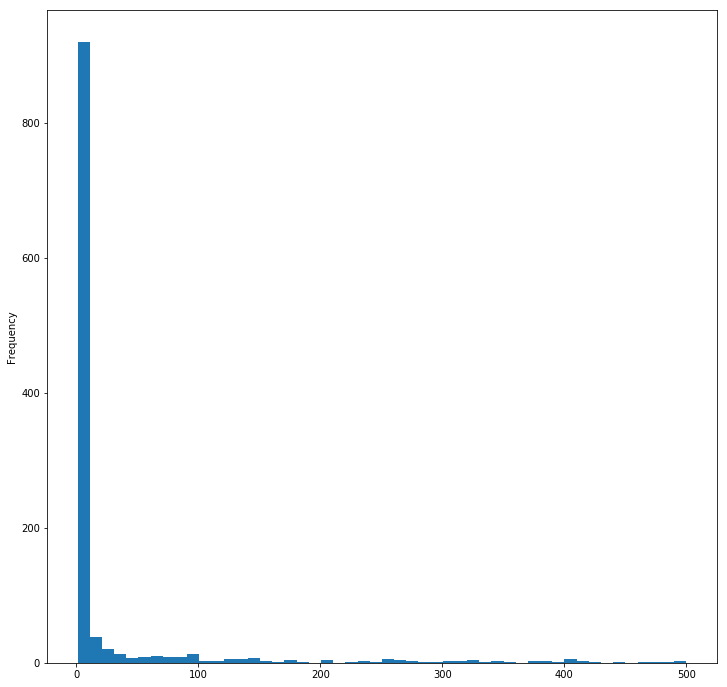

In [32]:
match_df["doc2vec_rank"].plot.hist(bins=50)

In [38]:
def shingle(text,k):

    text = text.lower()
    shingleLength = k
    tokens = text.split()

    shingles = [tokens[i:i+shingleLength] for i in range(len(tokens) - shingleLength + 1) if len(tokens[i]) < 4]
    shingles = ngrams(tokens,k)
    s_set = set()
    for s in shingles:
        s_set.add(s)

    return s_set

def jaccard(s1,s2):
    try:
        return len(s1.intersection(s2)) / len(s1.union(s2))
    except:
        return 0


hard_sims = similarity.objects.filter(
    doc2vec_sim__gt=0,
    jaccard__lt=0.1,
    #do_match=True
).order_by('doc2vec_sim')
for s in hard_sims[:5]:
    print('')
    d1 = scopus_doc.objects.get(scopus_id=s.scopus_id)
    print(d1.TI)
    print(d1.DO)
    d2 = Doc.objects.get(UT__UT=s.wos_ut)
    print(d2.title)
    print(d2.wosarticle.di)
    print(f"doc2vec sim: {s.doc2vec_sim}")
    print(f"jaccard (saved): {s.jaccard}")
    print(shingle(d1.TI,2))
    print(d2.shingle())
    print(jaccard(shingle(d1.TI,2),d2.shingle()))

    
